In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
import seaborn as sb
import optuna

train = pd.read_csv('playground-series-s4e5/train.csv')

train_eval_split = .8

train, eval = train_test_split(train,
                               train_size=train_eval_split,
                               random_state=42)


def transform_df(df):

    columns = list(df.columns)
    columns = [columns[i] for i in range(
        len(columns)) if columns[i] != 'id' and columns[i] != 'FloodProbability']

    df['sum'] = df[columns].sum(axis=1)
    df['mean'] = df[columns].mean(axis=1)
    df['median'] = df[columns].median(axis=1)
    df['std'] = df[columns].std(axis=1)
    df['skew'] = df[columns].skew(axis=1)
    df['mode'] = df[columns].mode(axis=1)[0]
    df['cv'] = df['std']/df['mean']
    df['max'] = df[columns].max(axis=1)
    df['min'] = df[columns].min(axis=1)
    df['25percent'] = df[columns].quantile(.25, axis=1)
    df['75percent'] = df[columns].quantile(.75, axis=1)

    df['harmonic'] = len(columns) / \
        df[columns].apply(lambda x: (1/x).mean(), axis=1)

    df['aggr1'] = df['MonsoonIntensity'] + df['ClimateChange'] + \
        df['WetlandLoss'] + df['Deforestation']

    df['aggr2'] = df['TopographyDrainage'] + \
        df['RiverManagement'] + df['DrainageSystems']

    df['aggr'] = np.log((df['aggr1'] * df['aggr2']) + 1)

    df = df.drop(['aggr1', 'aggr2'], axis=1)

    return df


train = transform_df(df=train)
eval = transform_df(df=eval)
print(train)

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,std,skew,mode,cv,max,min,25percent,75percent,harmonic,aggr
805665,805665,8,7,7,6,4,3,13,8,3,...,2.497894,1.074376,6.0,0.442105,13,2,4.00,7.00,91.838022,6.133398
863045,863045,7,4,4,2,4,5,7,3,6,...,1.877148,-0.239109,4.0,0.463493,7,0,2.75,5.25,0.000000,5.533389
496045,496045,6,5,1,6,6,7,3,5,6,...,1.777047,-0.062526,5.0,0.355409,9,1,4.00,6.00,80.318725,5.493061
1079364,1079364,4,6,6,3,3,3,1,5,4,...,2.134306,0.004421,4.0,0.458991,9,1,3.00,6.00,65.505589,5.880533
191800,191800,6,3,8,2,7,4,6,6,7,...,1.996708,0.322313,6.0,0.380325,10,2,4.00,6.00,88.351302,5.549076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,110268,4,7,5,4,4,5,3,8,4,...,1.848897,0.023178,4.0,0.406351,8,1,3.75,5.25,70.960929,5.476464
259178,259178,3,4,6,5,5,7,6,8,2,...,2.273416,-0.024487,3.0,0.428946,9,2,3.00,7.00,84.970075,5.669881
131932,131932,5,4,1,2,3,4,6,8,3,...,1.809333,0.389786,3.0,0.420775,8,1,3.00,5.25,68.445712,5.036953
671155,671155,6,10,4,6,3,6,3,3,5,...,1.663066,1.407608,5.0,0.342900,10,3,3.75,6.00,87.912088,5.926926


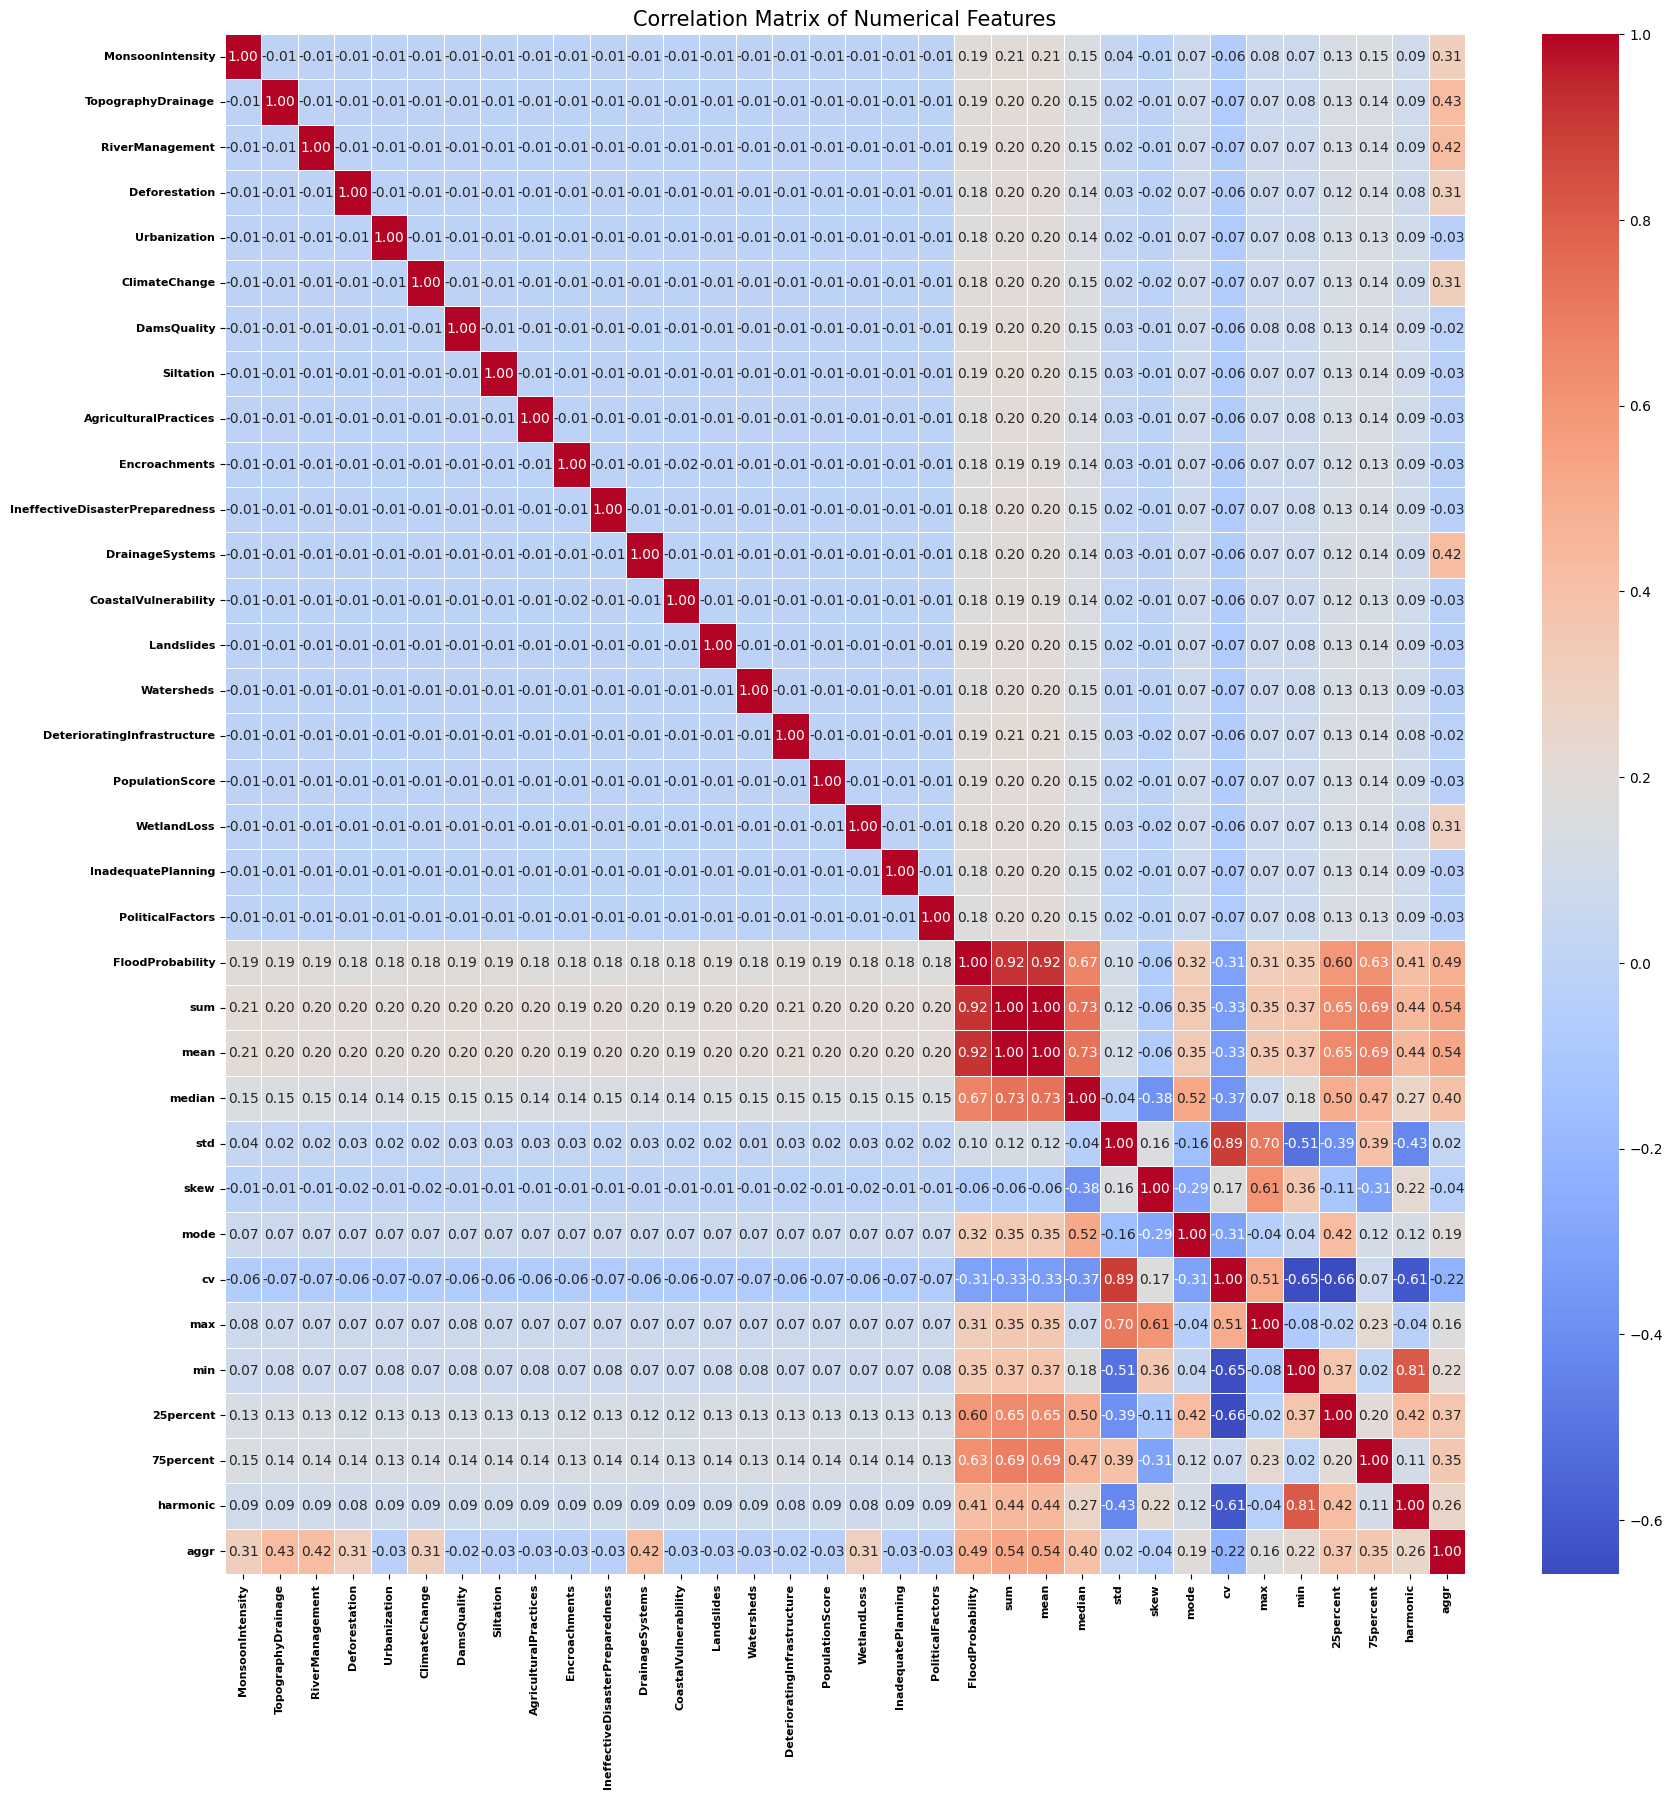

In [2]:
corr_matrix = train.drop(['id'], axis=1).corr()

plt.figure(figsize=(20, 20))
sb.heatmap(corr_matrix, linewidths=.5, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Matrix of Numerical Features', fontsize=15)
plt.xticks(fontsize=8, fontweight='bold')
plt.yticks(fontsize=8, fontweight='bold')
plt.show()

In [ ]:
scaler = StandardScaler()

features = list(train.columns)
features = [features[i] for i in range(
    len(features)) if features[i] != 'id' and features[i] != 'FloodProbability']

train[features] = scaler.fit_transform(train[features])
eval[features] = scaler.fit_transform(eval[features])

X_train, y_train = train[features], train['FloodProbability']
X_eval, y_eval = eval[features], eval['FloodProbability']

In [3]:
model = lgbm.LGBMRegressor(boosting_type='gbdt',
                           objective='regression',
                           num_leaves=30,
                           learning_rate=.05,
                           n_estimators=100)

model.fit(X_train,
          y_train,
          eval_metric='l2')

y_pred_train = model.predict(X_train, num_iteration=model.best_iteration_)
y_pred_eval = model.predict(X_eval, num_iteration=model.best_iteration_)

mse_train = mean_squared_error(y_pred=y_pred_train, y_true=y_train)
mse_eval = mean_squared_error(y_pred=y_pred_eval, y_true=y_eval)

r2_train = r2_score(y_pred=y_pred_train, y_true=y_train)
r2_eval = r2_score(y_pred=y_pred_eval, y_true=y_eval)

print(f'MSE Train: {mse_train:.5f}, MSE Eval: {mse_eval:.5f}')
print('---------------------------------------------')
print(f'R2 Train: {r2_train:.5f}, R2 Eval: {r2_eval:.5f}')
print('=============================================')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1879
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 33
[LightGBM] [Info] Start training from score 0.504480
MSE Train: 0.00034, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.86877, R2 Eval: 0.86835


In [ ]:
def objective(trial):

    model = lgbm.LGBMRegressor(objective='regression',
                               metric='rmse',
                               verbosity=-1,
                               boosting_type='gbdt',
                               lambda_l1=trial.suggest_float(
                                   'lambda_l1', 1e-8, 10.0, log=True),
                               lambda_l2=trial.suggest_float(
                                   'lambda_l2', 1e-8, 10.0, log=True),
                               num_leaves=trial.suggest_int(
                                   'num_leaves', 2, 256),
                               feature_fraction=trial.suggest_float(
                                   'feature_fraction', 0.4, 1.0),
                               bagging_fraction=trial.suggest_float(
                                   'bagging_fraction', 0.4, 1.0),
                               bagging_freq=trial.suggest_int(
                                   'bagging_freq', 1, 7),
                               min_child_samples=trial.suggest_int(
                                   'min_child_samples', 5, 100),
                               learning_rate=trial.suggest_float(
                                   'learning_rate', 1e-4, 1e-1, log=True),
                               random_state=42)

    model.fit(X_train,
              y_train,
              eval_set=[(X_eval, y_eval)])

    y_pred_train = model.predict(X_train, num_iteration=model.best_iteration_)
    y_pred_eval = model.predict(X_eval, num_iteration=model.best_iteration_)

    mse_train = mean_squared_error(y_pred=y_pred_train, y_true=y_train)
    mse_eval = mean_squared_error(y_pred=y_pred_eval, y_true=y_eval)

    r2_train = r2_score(y_pred=y_pred_train, y_true=y_train)
    r2_eval = r2_score(y_pred=y_pred_eval, y_true=y_eval)

    print(f'MSE Train: {mse_train:.5f}, MSE Eval: {mse_eval:.5f}')
    print('---------------------------------------------')
    print(f'R2 Train: {r2_train:.3f}, R2 Eval: {r2_eval:.3f}')
    print('=============================================')

    return mse_eval

In [4]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print(f'Best parameters: {study.best_params}')
print(f'Best MSE: {study.best_value}')

[I 2024-05-29 09:30:44,953] A new study created in memory with name: no-name-66eef0bf-98ce-454d-8731-fad0d0ecccfc
[I 2024-05-29 09:30:49,737] Trial 0 finished with value: 0.0008315995755500623 and parameters: {'lambda_l1': 1.631079962919946e-07, 'lambda_l2': 0.6487117222230293, 'num_leaves': 158, 'feature_fraction': 0.46492062038542664, 'bagging_fraction': 0.4272746011108937, 'bagging_freq': 2, 'min_child_samples': 91, 'learning_rate': 0.008074956886944339}. Best is trial 0 with value: 0.0008315995755500623.


MSE Train: 0.00083, MSE Eval: 0.00083
---------------------------------------------
R2 Train: 0.680, R2 Eval: 0.680


[I 2024-05-29 09:30:57,282] Trial 1 finished with value: 0.0025480109047117073 and parameters: {'lambda_l1': 0.008536426438104391, 'lambda_l2': 1.5826278915368275e-08, 'num_leaves': 158, 'feature_fraction': 0.737839445673288, 'bagging_fraction': 0.9678651056249219, 'bagging_freq': 6, 'min_child_samples': 89, 'learning_rate': 0.00011565900444135084}. Best is trial 0 with value: 0.0008315995755500623.


MSE Train: 0.00255, MSE Eval: 0.00255
---------------------------------------------
R2 Train: 0.020, R2 Eval: 0.020


[I 2024-05-29 09:31:02,372] Trial 2 finished with value: 0.00034149172742338983 and parameters: {'lambda_l1': 2.4320515247840713e-07, 'lambda_l2': 0.003568683236504175, 'num_leaves': 113, 'feature_fraction': 0.6722939606253755, 'bagging_fraction': 0.8573361291975861, 'bagging_freq': 1, 'min_child_samples': 12, 'learning_rate': 0.07781507952741448}. Best is trial 2 with value: 0.00034149172742338983.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.871, R2 Eval: 0.869


[I 2024-05-29 09:31:05,304] Trial 3 finished with value: 0.002316197168230918 and parameters: {'lambda_l1': 8.506111549251486, 'lambda_l2': 2.6266090822758757e-08, 'num_leaves': 22, 'feature_fraction': 0.8339648746868188, 'bagging_fraction': 0.5328965337462526, 'bagging_freq': 5, 'min_child_samples': 86, 'learning_rate': 0.0006854939102709667}. Best is trial 2 with value: 0.00034149172742338983.


MSE Train: 0.00232, MSE Eval: 0.00232
---------------------------------------------
R2 Train: 0.109, R2 Eval: 0.109


[I 2024-05-29 09:31:11,501] Trial 4 finished with value: 0.0003409451664346747 and parameters: {'lambda_l1': 3.496046474369472e-05, 'lambda_l2': 1.7846868702274843e-05, 'num_leaves': 172, 'feature_fraction': 0.7247515488646052, 'bagging_fraction': 0.9232621820961106, 'bagging_freq': 3, 'min_child_samples': 12, 'learning_rate': 0.0541139829298006}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.872, R2 Eval: 0.869


[I 2024-05-29 09:31:17,300] Trial 5 finished with value: 0.0003412236965656683 and parameters: {'lambda_l1': 0.04760456298082692, 'lambda_l2': 1.4140668553152453, 'num_leaves': 241, 'feature_fraction': 0.7488195278274186, 'bagging_fraction': 0.654576824571165, 'bagging_freq': 2, 'min_child_samples': 50, 'learning_rate': 0.06045826882163503}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.873, R2 Eval: 0.869


[I 2024-05-29 09:31:22,480] Trial 6 finished with value: 0.002077996107964143 and parameters: {'lambda_l1': 0.04040626214585894, 'lambda_l2': 1.0423620229061016e-08, 'num_leaves': 162, 'feature_fraction': 0.47077734347668077, 'bagging_fraction': 0.6332579674502985, 'bagging_freq': 6, 'min_child_samples': 56, 'learning_rate': 0.0013713215612918917}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00208, MSE Eval: 0.00208
---------------------------------------------
R2 Train: 0.201, R2 Eval: 0.201


[I 2024-05-29 09:31:26,769] Trial 7 finished with value: 0.0005284949382481971 and parameters: {'lambda_l1': 0.2003087093894192, 'lambda_l2': 0.020775821902000998, 'num_leaves': 83, 'feature_fraction': 0.43991460083931144, 'bagging_fraction': 0.6131819072888189, 'bagging_freq': 4, 'min_child_samples': 23, 'learning_rate': 0.013373693982104501}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00053, MSE Eval: 0.00053
---------------------------------------------
R2 Train: 0.797, R2 Eval: 0.797


[I 2024-05-29 09:31:28,796] Trial 8 finished with value: 0.0003732629734818933 and parameters: {'lambda_l1': 0.0005802110704720047, 'lambda_l2': 0.09672673849086934, 'num_leaves': 2, 'feature_fraction': 0.9037099399349215, 'bagging_fraction': 0.7675770771877766, 'bagging_freq': 6, 'min_child_samples': 67, 'learning_rate': 0.06354599361428415}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00037, MSE Eval: 0.00037
---------------------------------------------
R2 Train: 0.856, R2 Eval: 0.856


[I 2024-05-29 09:31:35,051] Trial 9 finished with value: 0.00214175503502638 and parameters: {'lambda_l1': 3.8419886299827924e-08, 'lambda_l2': 2.9357236997794718e-05, 'num_leaves': 153, 'feature_fraction': 0.7252944871878042, 'bagging_fraction': 0.736371359743947, 'bagging_freq': 2, 'min_child_samples': 41, 'learning_rate': 0.0011396597909503982}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00215, MSE Eval: 0.00214
---------------------------------------------
R2 Train: 0.176, R2 Eval: 0.176


[I 2024-05-29 09:31:42,805] Trial 10 finished with value: 0.0004510617221889145 and parameters: {'lambda_l1': 1.248237554392923e-05, 'lambda_l2': 8.997003403866477e-06, 'num_leaves': 236, 'feature_fraction': 0.5940366614923793, 'bagging_fraction': 0.9960201275522915, 'bagging_freq': 4, 'min_child_samples': 6, 'learning_rate': 0.01531423310075381}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00045, MSE Eval: 0.00045
---------------------------------------------
R2 Train: 0.828, R2 Eval: 0.826


[I 2024-05-29 09:31:49,753] Trial 11 finished with value: 0.0003426518889749411 and parameters: {'lambda_l1': 1.6273332122249683e-05, 'lambda_l2': 2.7364185381654225, 'num_leaves': 246, 'feature_fraction': 0.8174597815840606, 'bagging_fraction': 0.8037097324922515, 'bagging_freq': 3, 'min_child_samples': 34, 'learning_rate': 0.035345011276753754}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.871, R2 Eval: 0.868


[I 2024-05-29 09:31:56,503] Trial 12 finished with value: 0.0013566965129297923 and parameters: {'lambda_l1': 0.0002728374588955476, 'lambda_l2': 0.00026161418814411934, 'num_leaves': 208, 'feature_fraction': 0.9701866893810401, 'bagging_fraction': 0.8831644687639063, 'bagging_freq': 1, 'min_child_samples': 66, 'learning_rate': 0.003985237387462084}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00136, MSE Eval: 0.00136
---------------------------------------------
R2 Train: 0.478, R2 Eval: 0.478


[I 2024-05-29 09:32:01,604] Trial 13 finished with value: 0.0003638034097631535 and parameters: {'lambda_l1': 1.4494405194075004, 'lambda_l2': 2.0051606602831894e-05, 'num_leaves': 207, 'feature_fraction': 0.6076859272690839, 'bagging_fraction': 0.6544893876300564, 'bagging_freq': 3, 'min_child_samples': 37, 'learning_rate': 0.02460053544910465}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00036, MSE Eval: 0.00036
---------------------------------------------
R2 Train: 0.860, R2 Eval: 0.860


[I 2024-05-29 09:32:06,462] Trial 14 finished with value: 0.00034187631162642905 and parameters: {'lambda_l1': 0.002588799626211162, 'lambda_l2': 7.263430519246969e-07, 'num_leaves': 205, 'feature_fraction': 0.8013059429680196, 'bagging_fraction': 0.533841020921668, 'bagging_freq': 3, 'min_child_samples': 24, 'learning_rate': 0.09807576124620232}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.875, R2 Eval: 0.868


[I 2024-05-29 09:32:12,227] Trial 15 finished with value: 0.0011023102266769474 and parameters: {'lambda_l1': 1.5569816096005562e-05, 'lambda_l2': 0.0009056312351454633, 'num_leaves': 80, 'feature_fraction': 0.6060362249567901, 'bagging_fraction': 0.8966651843233566, 'bagging_freq': 2, 'min_child_samples': 54, 'learning_rate': 0.005575590722695549}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00110, MSE Eval: 0.00110
---------------------------------------------
R2 Train: 0.576, R2 Eval: 0.576


[I 2024-05-29 09:32:17,455] Trial 16 finished with value: 0.00034544083027533137 and parameters: {'lambda_l1': 0.0001921625990671859, 'lambda_l2': 9.069714554410934, 'num_leaves': 189, 'feature_fraction': 0.6805003145602829, 'bagging_fraction': 0.5404586612542425, 'bagging_freq': 3, 'min_child_samples': 18, 'learning_rate': 0.03207659566078412}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00034, MSE Eval: 0.00035
---------------------------------------------
R2 Train: 0.869, R2 Eval: 0.867


[I 2024-05-29 09:32:24,372] Trial 17 finished with value: 0.002516173648149656 and parameters: {'lambda_l1': 1.5964045549987305e-06, 'lambda_l2': 1.0496176667207408e-06, 'num_leaves': 236, 'feature_fraction': 0.8980524358721691, 'bagging_fraction': 0.7170313773713446, 'bagging_freq': 7, 'min_child_samples': 71, 'learning_rate': 0.00018738685627057406}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00252, MSE Eval: 0.00252
---------------------------------------------
R2 Train: 0.032, R2 Eval: 0.032


[I 2024-05-29 09:32:29,770] Trial 18 finished with value: 0.0003418035153249883 and parameters: {'lambda_l1': 0.22101135241682615, 'lambda_l2': 0.14965748266469153, 'num_leaves': 116, 'feature_fraction': 0.7680137094621258, 'bagging_fraction': 0.82610604015446, 'bagging_freq': 1, 'min_child_samples': 40, 'learning_rate': 0.04045968830632301}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00034, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.870, R2 Eval: 0.869


[I 2024-05-29 09:32:35,161] Trial 19 finished with value: 0.0005179391390077709 and parameters: {'lambda_l1': 0.009047174179164197, 'lambda_l2': 0.007233915237891587, 'num_leaves': 252, 'feature_fraction': 0.5510045155450226, 'bagging_fraction': 0.4024412851437387, 'bagging_freq': 2, 'min_child_samples': 78, 'learning_rate': 0.013058852534439135}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00052, MSE Eval: 0.00052
---------------------------------------------
R2 Train: 0.802, R2 Eval: 0.801


[I 2024-05-29 09:32:44,253] Trial 20 finished with value: 0.0018703146555232115 and parameters: {'lambda_l1': 4.2232020623415056e-05, 'lambda_l2': 4.6900367250791543e-07, 'num_leaves': 183, 'feature_fraction': 0.876842004822067, 'bagging_fraction': 0.9412796258892558, 'bagging_freq': 5, 'min_child_samples': 48, 'learning_rate': 0.001948459841406864}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00187, MSE Eval: 0.00187
---------------------------------------------
R2 Train: 0.280, R2 Eval: 0.280


[I 2024-05-29 09:32:49,347] Trial 21 finished with value: 0.00034150768154865113 and parameters: {'lambda_l1': 7.946760589758937e-07, 'lambda_l2': 0.0008748486247758794, 'num_leaves': 116, 'feature_fraction': 0.6687058815833423, 'bagging_fraction': 0.8598124527581961, 'bagging_freq': 1, 'min_child_samples': 6, 'learning_rate': 0.07535789517884924}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.872, R2 Eval: 0.869


[I 2024-05-29 09:32:54,823] Trial 22 finished with value: 0.0003413829546472555 and parameters: {'lambda_l1': 5.1919727472896853e-08, 'lambda_l2': 0.00019291225737597082, 'num_leaves': 96, 'feature_fraction': 0.6638506354110701, 'bagging_fraction': 0.9290423032824244, 'bagging_freq': 1, 'min_child_samples': 13, 'learning_rate': 0.053438091789585224}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00034, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.870, R2 Eval: 0.869


[I 2024-05-29 09:33:00,450] Trial 23 finished with value: 0.00036814809028535027 and parameters: {'lambda_l1': 1.0965575945868221e-08, 'lambda_l2': 0.00010188261767184513, 'num_leaves': 72, 'feature_fraction': 0.5325429079150714, 'bagging_fraction': 0.9132128827865168, 'bagging_freq': 2, 'min_child_samples': 27, 'learning_rate': 0.023245520943311827}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00037, MSE Eval: 0.00037
---------------------------------------------
R2 Train: 0.859, R2 Eval: 0.858


[I 2024-05-29 09:33:05,004] Trial 24 finished with value: 0.0003421021221892662 and parameters: {'lambda_l1': 1.6870257609423917e-06, 'lambda_l2': 2.7781578520238697e-06, 'num_leaves': 53, 'feature_fraction': 0.7672427368991848, 'bagging_fraction': 0.6702840524394801, 'bagging_freq': 3, 'min_child_samples': 15, 'learning_rate': 0.04154173911791406}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00034, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.869, R2 Eval: 0.868


[I 2024-05-29 09:33:11,272] Trial 25 finished with value: 0.0007538558184765852 and parameters: {'lambda_l1': 0.0014974533056396216, 'lambda_l2': 0.00015045557216785085, 'num_leaves': 137, 'feature_fraction': 0.6560529203433216, 'bagging_fraction': 0.7666124107791903, 'bagging_freq': 1, 'min_child_samples': 98, 'learning_rate': 0.008601743335947844}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00075, MSE Eval: 0.00075
---------------------------------------------
R2 Train: 0.710, R2 Eval: 0.710


[I 2024-05-29 09:33:15,838] Trial 26 finished with value: 0.0003410069067666131 and parameters: {'lambda_l1': 0.07634793172670912, 'lambda_l2': 1.218535270876724e-07, 'num_leaves': 96, 'feature_fraction': 0.717414553966966, 'bagging_fraction': 0.5750066941969496, 'bagging_freq': 2, 'min_child_samples': 30, 'learning_rate': 0.05188323986527675}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00034, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.870, R2 Eval: 0.869


[I 2024-05-29 09:33:19,557] Trial 27 finished with value: 0.0003414017165073078 and parameters: {'lambda_l1': 0.08338211983659004, 'lambda_l2': 1.4397263858578448e-07, 'num_leaves': 46, 'feature_fraction': 0.7414392089000466, 'bagging_fraction': 0.5891771027876399, 'bagging_freq': 4, 'min_child_samples': 48, 'learning_rate': 0.09830221564122565}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00034, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.870, R2 Eval: 0.869


[I 2024-05-29 09:33:23,148] Trial 28 finished with value: 0.00037877122956359927 and parameters: {'lambda_l1': 1.8717752577132136, 'lambda_l2': 1.6523138485014222e-07, 'num_leaves': 139, 'feature_fraction': 0.7123481776438934, 'bagging_fraction': 0.47476507982042565, 'bagging_freq': 2, 'min_child_samples': 29, 'learning_rate': 0.021484630883679794}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00038, MSE Eval: 0.00038
---------------------------------------------
R2 Train: 0.855, R2 Eval: 0.854


[I 2024-05-29 09:33:28,654] Trial 29 finished with value: 0.0007437183421433398 and parameters: {'lambda_l1': 0.02012815224817013, 'lambda_l2': 5.667335787707343e-06, 'num_leaves': 222, 'feature_fraction': 0.8518426166723547, 'bagging_fraction': 0.469381872808477, 'bagging_freq': 3, 'min_child_samples': 32, 'learning_rate': 0.00860179276681385}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00074, MSE Eval: 0.00074
---------------------------------------------
R2 Train: 0.715, R2 Eval: 0.714


[I 2024-05-29 09:33:32,656] Trial 30 finished with value: 0.0024138461991303727 and parameters: {'lambda_l1': 0.4732902726124871, 'lambda_l2': 1.0169993172403982e-07, 'num_leaves': 183, 'feature_fraction': 0.7807030703386225, 'bagging_fraction': 0.5846405072337213, 'bagging_freq': 4, 'min_child_samples': 61, 'learning_rate': 0.0004308177693701364}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00242, MSE Eval: 0.00241
---------------------------------------------
R2 Train: 0.071, R2 Eval: 0.071


[I 2024-05-29 09:33:37,560] Trial 31 finished with value: 0.00034138104388927663 and parameters: {'lambda_l1': 0.0033505027877177252, 'lambda_l2': 4.384023886806539e-05, 'num_leaves': 98, 'feature_fraction': 0.6959876461718698, 'bagging_fraction': 0.6742207127313874, 'bagging_freq': 2, 'min_child_samples': 20, 'learning_rate': 0.05250655821451299}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00034, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.870, R2 Eval: 0.869


[I 2024-05-29 09:33:42,606] Trial 32 finished with value: 0.0003414109581396684 and parameters: {'lambda_l1': 0.0030150699135919564, 'lambda_l2': 5.065269488194178e-05, 'num_leaves': 101, 'feature_fraction': 0.6367956207529866, 'bagging_fraction': 0.6831496061862067, 'bagging_freq': 2, 'min_child_samples': 20, 'learning_rate': 0.05123872966298017}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00034, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.870, R2 Eval: 0.869


[I 2024-05-29 09:33:47,529] Trial 33 finished with value: 0.0003952798472650464 and parameters: {'lambda_l1': 7.926895657465242e-05, 'lambda_l2': 0.0011590587804973696, 'num_leaves': 64, 'feature_fraction': 0.7068012456415196, 'bagging_fraction': 0.7049927881120637, 'bagging_freq': 2, 'min_child_samples': 44, 'learning_rate': 0.018901845450183405}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00040, MSE Eval: 0.00040
---------------------------------------------
R2 Train: 0.848, R2 Eval: 0.848


[I 2024-05-29 09:33:52,439] Trial 34 finished with value: 0.00034097574317355284 and parameters: {'lambda_l1': 0.015214875130789497, 'lambda_l2': 2.0621835103703364e-06, 'num_leaves': 165, 'feature_fraction': 0.7441837719086285, 'bagging_fraction': 0.5963341753081715, 'bagging_freq': 2, 'min_child_samples': 10, 'learning_rate': 0.059953897408703945}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.872, R2 Eval: 0.869


[I 2024-05-29 09:33:57,752] Trial 35 finished with value: 0.0003452067614733556 and parameters: {'lambda_l1': 0.03040262467867991, 'lambda_l2': 4.608089710665246e-08, 'num_leaves': 171, 'feature_fraction': 0.7501313064001135, 'bagging_fraction': 0.5685989234263226, 'bagging_freq': 3, 'min_child_samples': 10, 'learning_rate': 0.031199015712921566}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00034, MSE Eval: 0.00035
---------------------------------------------
R2 Train: 0.869, R2 Eval: 0.867


[I 2024-05-29 09:34:02,282] Trial 36 finished with value: 0.0003416356787767685 and parameters: {'lambda_l1': 0.009703282085455244, 'lambda_l2': 2.3220374946954588e-06, 'num_leaves': 150, 'feature_fraction': 0.7971728533837562, 'bagging_fraction': 0.48598004530433675, 'bagging_freq': 2, 'min_child_samples': 10, 'learning_rate': 0.06869993312067967}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.872, R2 Eval: 0.869


[I 2024-05-29 09:34:05,726] Trial 37 finished with value: 0.0006058415316278379 and parameters: {'lambda_l1': 7.049930958263421, 'lambda_l2': 3.3779813106903135e-07, 'num_leaves': 166, 'feature_fraction': 0.8487260560595468, 'bagging_fraction': 0.6284943967444389, 'bagging_freq': 3, 'min_child_samples': 27, 'learning_rate': 0.011066155955765194}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00061, MSE Eval: 0.00061
---------------------------------------------
R2 Train: 0.767, R2 Eval: 0.767


[I 2024-05-29 09:34:10,388] Trial 38 finished with value: 0.0010466427778578178 and parameters: {'lambda_l1': 0.08703236399891258, 'lambda_l2': 7.812030305272056e-06, 'num_leaves': 130, 'feature_fraction': 0.7360519636992735, 'bagging_fraction': 0.5100549330491486, 'bagging_freq': 5, 'min_child_samples': 17, 'learning_rate': 0.00585351088563294}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00105, MSE Eval: 0.00105
---------------------------------------------
R2 Train: 0.597, R2 Eval: 0.597


[I 2024-05-29 09:34:15,914] Trial 39 finished with value: 0.0003416586018021716 and parameters: {'lambda_l1': 0.0008674622491076006, 'lambda_l2': 2.876382444982904e-08, 'num_leaves': 220, 'feature_fraction': 0.6347916408347952, 'bagging_fraction': 0.6163655674948968, 'bagging_freq': 1, 'min_child_samples': 33, 'learning_rate': 0.06868738564134305}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.874, R2 Eval: 0.869


[I 2024-05-29 09:34:21,673] Trial 40 finished with value: 0.00034170558208095135 and parameters: {'lambda_l1': 0.4107797371939023, 'lambda_l2': 0.6111849246179256, 'num_leaves': 194, 'feature_fraction': 0.9500843541688271, 'bagging_fraction': 0.5583746547081833, 'bagging_freq': 3, 'min_child_samples': 48, 'learning_rate': 0.09906339574292433}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.872, R2 Eval: 0.869


[I 2024-05-29 09:34:26,627] Trial 41 finished with value: 0.00034146493948903825 and parameters: {'lambda_l1': 0.0045393838122361205, 'lambda_l2': 2.0668418558851856e-06, 'num_leaves': 97, 'feature_fraction': 0.7120849136317184, 'bagging_fraction': 0.6401617704617306, 'bagging_freq': 2, 'min_child_samples': 21, 'learning_rate': 0.04873343190490834}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00034, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.870, R2 Eval: 0.869


[I 2024-05-29 09:34:31,900] Trial 42 finished with value: 0.0003473973854803825 and parameters: {'lambda_l1': 0.05462157547395963, 'lambda_l2': 1.980169693149199e-05, 'num_leaves': 150, 'feature_fraction': 0.6919709057826435, 'bagging_fraction': 0.6029197109072597, 'bagging_freq': 2, 'min_child_samples': 5, 'learning_rate': 0.029689703785977475}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00034, MSE Eval: 0.00035
---------------------------------------------
R2 Train: 0.868, R2 Eval: 0.866


[I 2024-05-29 09:34:37,467] Trial 43 finished with value: 0.00034094531877837007 and parameters: {'lambda_l1': 0.01874467134903255, 'lambda_l2': 6.0888812285522506e-05, 'num_leaves': 110, 'feature_fraction': 0.8176080872599264, 'bagging_fraction': 0.7513935891519992, 'bagging_freq': 2, 'min_child_samples': 11, 'learning_rate': 0.056287110261868674}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00034, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.871, R2 Eval: 0.869


[I 2024-05-29 09:34:43,830] Trial 44 finished with value: 0.0004010178078035773 and parameters: {'lambda_l1': 0.016169797441533372, 'lambda_l2': 0.01818347121309556, 'num_leaves': 123, 'feature_fraction': 0.794374477547025, 'bagging_fraction': 0.7484382478638791, 'bagging_freq': 1, 'min_child_samples': 11, 'learning_rate': 0.018052098840906958}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00040, MSE Eval: 0.00040
---------------------------------------------
R2 Train: 0.846, R2 Eval: 0.846


[I 2024-05-29 09:34:49,653] Trial 45 finished with value: 0.0003423673082929727 and parameters: {'lambda_l1': 0.18561589711408719, 'lambda_l2': 1.2778753402857713e-05, 'num_leaves': 108, 'feature_fraction': 0.8165449815187568, 'bagging_fraction': 0.8173578199240769, 'bagging_freq': 2, 'min_child_samples': 24, 'learning_rate': 0.036980169711451884}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00034, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.869, R2 Eval: 0.868


[I 2024-05-29 09:34:53,306] Trial 46 finished with value: 0.00034259967549745275 and parameters: {'lambda_l1': 1.7179748618283874, 'lambda_l2': 0.0028968730580193405, 'num_leaves': 30, 'feature_fraction': 0.8371095098994292, 'bagging_fraction': 0.5092730884085037, 'bagging_freq': 4, 'min_child_samples': 15, 'learning_rate': 0.07042028365876991}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00034, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.869, R2 Eval: 0.868


[I 2024-05-29 09:34:59,084] Trial 47 finished with value: 0.0003482368581545978 and parameters: {'lambda_l1': 0.0008587997309538298, 'lambda_l2': 1.3295553809983434e-06, 'num_leaves': 84, 'feature_fraction': 0.874063172401992, 'bagging_fraction': 0.718933722240218, 'bagging_freq': 3, 'min_child_samples': 58, 'learning_rate': 0.02846466939688326}. Best is trial 4 with value: 0.0003409451664346747.


MSE Train: 0.00035, MSE Eval: 0.00035
---------------------------------------------
R2 Train: 0.867, R2 Eval: 0.866


[I 2024-05-29 09:35:06,099] Trial 48 finished with value: 0.0003407517952332694 and parameters: {'lambda_l1': 0.00033296070132509114, 'lambda_l2': 5.588049229805785e-06, 'num_leaves': 162, 'feature_fraction': 0.7611808524276186, 'bagging_fraction': 0.9929433817356622, 'bagging_freq': 3, 'min_child_samples': 38, 'learning_rate': 0.05714832510062117}. Best is trial 48 with value: 0.0003407517952332694.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.872, R2 Eval: 0.869


[I 2024-05-29 09:35:14,427] Trial 49 finished with value: 0.0003410269113809163 and parameters: {'lambda_l1': 5.9714944444050335e-06, 'lambda_l2': 4.723579746194809e-06, 'num_leaves': 175, 'feature_fraction': 0.9353889742778664, 'bagging_fraction': 0.9901585025775217, 'bagging_freq': 4, 'min_child_samples': 38, 'learning_rate': 0.044538763033491094}. Best is trial 48 with value: 0.0003407517952332694.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.872, R2 Eval: 0.869


[I 2024-05-29 09:35:22,063] Trial 50 finished with value: 0.001506923312693002 and parameters: {'lambda_l1': 0.00012320637214462943, 'lambda_l2': 6.13523899591472e-05, 'num_leaves': 140, 'feature_fraction': 0.7589047655543928, 'bagging_fraction': 0.9644012533497899, 'bagging_freq': 3, 'min_child_samples': 30, 'learning_rate': 0.003318395737666195}. Best is trial 48 with value: 0.0003407517952332694.


MSE Train: 0.00151, MSE Eval: 0.00151
---------------------------------------------
R2 Train: 0.420, R2 Eval: 0.420


[I 2024-05-29 09:35:29,341] Trial 51 finished with value: 0.00034103187939404055 and parameters: {'lambda_l1': 5.840433268452085e-06, 'lambda_l2': 3.6093076319606647e-06, 'num_leaves': 159, 'feature_fraction': 0.9632735711506821, 'bagging_fraction': 0.9940251271329488, 'bagging_freq': 4, 'min_child_samples': 40, 'learning_rate': 0.042957493437761264}. Best is trial 48 with value: 0.0003407517952332694.


MSE Train: 0.00034, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.871, R2 Eval: 0.869


[I 2024-05-29 09:35:36,301] Trial 52 finished with value: 0.00034079073084246787 and parameters: {'lambda_l1': 5.89282436327786e-05, 'lambda_l2': 2.899298993733937e-07, 'num_leaves': 173, 'feature_fraction': 0.9345702263174022, 'bagging_fraction': 0.9518621562461412, 'bagging_freq': 5, 'min_child_samples': 37, 'learning_rate': 0.08046791664841965}. Best is trial 48 with value: 0.0003407517952332694.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.873, R2 Eval: 0.869


[I 2024-05-29 09:35:43,775] Trial 53 finished with value: 0.000340740997395524 and parameters: {'lambda_l1': 3.671575148742974e-05, 'lambda_l2': 3.5717097395167116e-07, 'num_leaves': 176, 'feature_fraction': 0.9324241732989388, 'bagging_fraction': 0.9577205941358004, 'bagging_freq': 5, 'min_child_samples': 43, 'learning_rate': 0.06400603322154963}. Best is trial 53 with value: 0.000340740997395524.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.873, R2 Eval: 0.869


[I 2024-05-29 09:35:51,032] Trial 54 finished with value: 0.0003410196882190576 and parameters: {'lambda_l1': 4.6852385775032495e-05, 'lambda_l2': 5.265055939749056e-07, 'num_leaves': 199, 'feature_fraction': 0.9951788395251411, 'bagging_fraction': 0.9445764991809882, 'bagging_freq': 6, 'min_child_samples': 36, 'learning_rate': 0.08326232410554325}. Best is trial 53 with value: 0.000340740997395524.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.874, R2 Eval: 0.869


[I 2024-05-29 09:35:58,227] Trial 55 finished with value: 0.0003408840091259743 and parameters: {'lambda_l1': 0.00035127355542835363, 'lambda_l2': 1.050911562329938e-06, 'num_leaves': 176, 'feature_fraction': 0.9339364297060542, 'bagging_fraction': 0.8963354034203834, 'bagging_freq': 5, 'min_child_samples': 44, 'learning_rate': 0.06075928684299945}. Best is trial 53 with value: 0.000340740997395524.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.873, R2 Eval: 0.869


[I 2024-05-29 09:36:04,741] Trial 56 finished with value: 0.00034100295170226693 and parameters: {'lambda_l1': 3.2081580891408624e-05, 'lambda_l2': 2.6732701926222577e-07, 'num_leaves': 180, 'feature_fraction': 0.9200566213673533, 'bagging_fraction': 0.8798469646883776, 'bagging_freq': 5, 'min_child_samples': 46, 'learning_rate': 0.08254819306736143}. Best is trial 53 with value: 0.000340740997395524.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.874, R2 Eval: 0.869


[I 2024-05-29 09:36:13,853] Trial 57 finished with value: 0.0003530681995660749 and parameters: {'lambda_l1': 0.0003984022312375993, 'lambda_l2': 7.804483083530043e-07, 'num_leaves': 151, 'feature_fraction': 0.9955151002838079, 'bagging_fraction': 0.9680440053665853, 'bagging_freq': 5, 'min_child_samples': 52, 'learning_rate': 0.025762620676327702}. Best is trial 53 with value: 0.000340740997395524.


MSE Train: 0.00035, MSE Eval: 0.00035
---------------------------------------------
R2 Train: 0.865, R2 Eval: 0.864


[I 2024-05-29 09:36:22,538] Trial 58 finished with value: 0.0018395234677469497 and parameters: {'lambda_l1': 0.0002337762285245471, 'lambda_l2': 1.3482494510000064e-08, 'num_leaves': 214, 'feature_fraction': 0.8864761041046486, 'bagging_fraction': 0.8517673951580108, 'bagging_freq': 6, 'min_child_samples': 43, 'learning_rate': 0.0020497646933242963}. Best is trial 53 with value: 0.000340740997395524.


MSE Train: 0.00184, MSE Eval: 0.00184
---------------------------------------------
R2 Train: 0.292, R2 Eval: 0.292


[I 2024-05-29 09:36:31,696] Trial 59 finished with value: 0.002552621570678235 and parameters: {'lambda_l1': 8.672187132774152e-06, 'lambda_l2': 4.743820782273717e-08, 'num_leaves': 192, 'feature_fraction': 0.9148190679219861, 'bagging_fraction': 0.910011208174306, 'bagging_freq': 6, 'min_child_samples': 55, 'learning_rate': 0.00010433574310292575}. Best is trial 53 with value: 0.000340740997395524.


MSE Train: 0.00256, MSE Eval: 0.00255
---------------------------------------------
R2 Train: 0.018, R2 Eval: 0.018


[I 2024-05-29 09:36:40,785] Trial 60 finished with value: 0.00044331950478195773 and parameters: {'lambda_l1': 2.8070169159505336e-06, 'lambda_l2': 0.0004943839980822878, 'num_leaves': 174, 'feature_fraction': 0.9336070546571206, 'bagging_fraction': 0.9662813802169137, 'bagging_freq': 5, 'min_child_samples': 36, 'learning_rate': 0.015337297083403915}. Best is trial 53 with value: 0.000340740997395524.


MSE Train: 0.00044, MSE Eval: 0.00044
---------------------------------------------
R2 Train: 0.830, R2 Eval: 0.829


[I 2024-05-29 09:36:47,474] Trial 61 finished with value: 0.0003408777247967281 and parameters: {'lambda_l1': 9.860627283407347e-05, 'lambda_l2': 1.3896333959905974e-05, 'num_leaves': 165, 'feature_fraction': 0.8655250523073946, 'bagging_fraction': 0.9278475986690075, 'bagging_freq': 7, 'min_child_samples': 7, 'learning_rate': 0.06549239258839525}. Best is trial 53 with value: 0.000340740997395524.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.873, R2 Eval: 0.869


[I 2024-05-29 09:36:55,197] Trial 62 finished with value: 0.0003421944891423997 and parameters: {'lambda_l1': 9.576401343117376e-05, 'lambda_l2': 2.5893409083145093e-05, 'num_leaves': 158, 'feature_fraction': 0.8662476736228671, 'bagging_fraction': 0.9350887308020063, 'bagging_freq': 7, 'min_child_samples': 44, 'learning_rate': 0.036400032599470805}. Best is trial 53 with value: 0.000340740997395524.


MSE Train: 0.00034, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.870, R2 Eval: 0.868


[I 2024-05-29 09:37:01,782] Trial 63 finished with value: 0.000340880601936931 and parameters: {'lambda_l1': 2.2620298311848853e-05, 'lambda_l2': 1.4178379034250467e-05, 'num_leaves': 187, 'feature_fraction': 0.8977070666328479, 'bagging_fraction': 0.8813391764830885, 'bagging_freq': 6, 'min_child_samples': 52, 'learning_rate': 0.08232147170981026}. Best is trial 53 with value: 0.000340740997395524.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.874, R2 Eval: 0.869


[I 2024-05-29 09:37:08,674] Trial 64 finished with value: 0.0003408936598897976 and parameters: {'lambda_l1': 2.2675485254787862e-05, 'lambda_l2': 1.1941180163224139e-05, 'num_leaves': 202, 'feature_fraction': 0.9025987456528172, 'bagging_fraction': 0.8779217510763667, 'bagging_freq': 7, 'min_child_samples': 61, 'learning_rate': 0.08485846555103593}. Best is trial 53 with value: 0.000340740997395524.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.874, R2 Eval: 0.869


[I 2024-05-29 09:37:15,384] Trial 65 finished with value: 0.0003408997487856895 and parameters: {'lambda_l1': 1.6464388755755167e-05, 'lambda_l2': 1.1639019251297682e-05, 'num_leaves': 203, 'feature_fraction': 0.8977351595894276, 'bagging_fraction': 0.8892353168243259, 'bagging_freq': 7, 'min_child_samples': 64, 'learning_rate': 0.08530490630325442}. Best is trial 53 with value: 0.000340740997395524.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.874, R2 Eval: 0.869


[I 2024-05-29 09:37:22,518] Trial 66 finished with value: 0.000340755196917366 and parameters: {'lambda_l1': 2.619133618268957e-05, 'lambda_l2': 1.1033541411859628e-06, 'num_leaves': 186, 'feature_fraction': 0.9741084386531494, 'bagging_fraction': 0.8600061938600947, 'bagging_freq': 7, 'min_child_samples': 74, 'learning_rate': 0.06799049820535719}. Best is trial 53 with value: 0.000340740997395524.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.873, R2 Eval: 0.869


[I 2024-05-29 09:37:30,062] Trial 67 finished with value: 0.0003407227087911642 and parameters: {'lambda_l1': 6.24269603187764e-05, 'lambda_l2': 1.269114053440565e-06, 'num_leaves': 185, 'feature_fraction': 0.9747053290432176, 'bagging_fraction': 0.9073121560886187, 'bagging_freq': 6, 'min_child_samples': 79, 'learning_rate': 0.06699147275881849}. Best is trial 67 with value: 0.0003407227087911642.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.873, R2 Eval: 0.869


[I 2024-05-29 09:37:37,642] Trial 68 finished with value: 0.0023774175704533956 and parameters: {'lambda_l1': 6.0439425258876495e-05, 'lambda_l2': 2.5412216589797146e-07, 'num_leaves': 187, 'feature_fraction': 0.9801589755433776, 'bagging_fraction': 0.9518100917310715, 'bagging_freq': 6, 'min_child_samples': 81, 'learning_rate': 0.0005167338810983337}. Best is trial 67 with value: 0.0003407227087911642.


MSE Train: 0.00238, MSE Eval: 0.00238
---------------------------------------------
R2 Train: 0.085, R2 Eval: 0.085


[I 2024-05-29 09:37:44,964] Trial 69 finished with value: 0.0003409618072809638 and parameters: {'lambda_l1': 0.00014572727922645037, 'lambda_l2': 6.162203435787473e-08, 'num_leaves': 224, 'feature_fraction': 0.9653475284028764, 'bagging_fraction': 0.8471057891455344, 'bagging_freq': 7, 'min_child_samples': 75, 'learning_rate': 0.06755514008370488}. Best is trial 67 with value: 0.0003407227087911642.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.874, R2 Eval: 0.869


[I 2024-05-29 09:37:53,118] Trial 70 finished with value: 0.000341153398914898 and parameters: {'lambda_l1': 3.5589336480773676e-06, 'lambda_l2': 1.2787130353343776e-06, 'num_leaves': 192, 'feature_fraction': 0.9462939260364138, 'bagging_fraction': 0.9243968753002876, 'bagging_freq': 6, 'min_child_samples': 86, 'learning_rate': 0.042027044317927434}. Best is trial 67 with value: 0.0003407227087911642.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.872, R2 Eval: 0.869


[I 2024-05-29 09:37:58,983] Trial 71 finished with value: 0.00034113334926838817 and parameters: {'lambda_l1': 0.0003255338709206194, 'lambda_l2': 6.680786473923133e-07, 'num_leaves': 180, 'feature_fraction': 0.9240324088374394, 'bagging_fraction': 0.9064162676142744, 'bagging_freq': 5, 'min_child_samples': 51, 'learning_rate': 0.09929174214844762}. Best is trial 67 with value: 0.0003407227087911642.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.874, R2 Eval: 0.869


[I 2024-05-29 09:38:05,842] Trial 72 finished with value: 0.00034077632116231657 and parameters: {'lambda_l1': 0.00048643610666731694, 'lambda_l2': 5.939661687475523e-06, 'num_leaves': 167, 'feature_fraction': 0.9788655968027257, 'bagging_fraction': 0.9836206297732707, 'bagging_freq': 7, 'min_child_samples': 93, 'learning_rate': 0.0611001722013878}. Best is trial 67 with value: 0.0003407227087911642.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.872, R2 Eval: 0.869


[I 2024-05-29 09:38:13,988] Trial 73 finished with value: 0.0003407169301257413 and parameters: {'lambda_l1': 2.8105770484267227e-05, 'lambda_l2': 5.610332605449778e-06, 'num_leaves': 168, 'feature_fraction': 0.979306890370113, 'bagging_fraction': 0.9768727597595968, 'bagging_freq': 7, 'min_child_samples': 96, 'learning_rate': 0.057723147590054084}. Best is trial 73 with value: 0.0003407169301257413.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.872, R2 Eval: 0.869


[I 2024-05-29 09:38:21,995] Trial 74 finished with value: 0.00034071063323011795 and parameters: {'lambda_l1': 0.0014440600814729229, 'lambda_l2': 6.661036607855576e-06, 'num_leaves': 164, 'feature_fraction': 0.9805996596946568, 'bagging_fraction': 0.9811137782002536, 'bagging_freq': 7, 'min_child_samples': 92, 'learning_rate': 0.060820400057948275}. Best is trial 74 with value: 0.00034071063323011795.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.872, R2 Eval: 0.869


[I 2024-05-29 09:38:28,935] Trial 75 finished with value: 0.0003422343331459648 and parameters: {'lambda_l1': 0.0007263368320336773, 'lambda_l2': 3.3697252626689727e-06, 'num_leaves': 144, 'feature_fraction': 0.9762565383757557, 'bagging_fraction': 0.9801079553293216, 'bagging_freq': 7, 'min_child_samples': 95, 'learning_rate': 0.03609834517474431}. Best is trial 74 with value: 0.00034071063323011795.


MSE Train: 0.00034, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.870, R2 Eval: 0.868


[I 2024-05-29 09:38:37,141] Trial 76 finished with value: 0.0003407112751370216 and parameters: {'lambda_l1': 0.00017318740674473568, 'lambda_l2': 6.647962212212992e-06, 'num_leaves': 169, 'feature_fraction': 0.9533713010939658, 'bagging_fraction': 0.9761276641199741, 'bagging_freq': 7, 'min_child_samples': 91, 'learning_rate': 0.04927608758393157}. Best is trial 74 with value: 0.00034071063323011795.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.872, R2 Eval: 0.869


[I 2024-05-29 09:38:45,188] Trial 77 finished with value: 0.0003406904674203366 and parameters: {'lambda_l1': 0.0012053404748796433, 'lambda_l2': 5.359199013473371e-06, 'num_leaves': 132, 'feature_fraction': 0.9553566175442579, 'bagging_fraction': 0.9985419563539962, 'bagging_freq': 7, 'min_child_samples': 91, 'learning_rate': 0.05178277491257566}. Best is trial 77 with value: 0.0003406904674203366.


MSE Train: 0.00034, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.871, R2 Eval: 0.869


[I 2024-05-29 09:38:53,448] Trial 78 finished with value: 0.00034085812605795995 and parameters: {'lambda_l1': 0.00018449489851207613, 'lambda_l2': 0.00010489901192809892, 'num_leaves': 130, 'feature_fraction': 0.9596011162604675, 'bagging_fraction': 0.9979763016151143, 'bagging_freq': 7, 'min_child_samples': 89, 'learning_rate': 0.047839202067404225}. Best is trial 77 with value: 0.0003406904674203366.


MSE Train: 0.00034, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.871, R2 Eval: 0.869


[I 2024-05-29 09:39:03,213] Trial 79 finished with value: 0.0025276073319845742 and parameters: {'lambda_l1': 2.6990199708214085e-07, 'lambda_l2': 1.6583065191754513e-06, 'num_leaves': 154, 'feature_fraction': 0.9869198144181808, 'bagging_fraction': 0.9714959817110635, 'bagging_freq': 7, 'min_child_samples': 84, 'learning_rate': 0.00016119655329432483}. Best is trial 77 with value: 0.0003406904674203366.


MSE Train: 0.00253, MSE Eval: 0.00253
---------------------------------------------
R2 Train: 0.028, R2 Eval: 0.028


[I 2024-05-29 09:39:12,442] Trial 80 finished with value: 0.0003522309309542578 and parameters: {'lambda_l1': 0.0012568310651102053, 'lambda_l2': 6.819074667756466e-06, 'num_leaves': 213, 'feature_fraction': 0.9530376603500055, 'bagging_fraction': 0.9565991049351565, 'bagging_freq': 7, 'min_child_samples': 100, 'learning_rate': 0.02607254660214375}. Best is trial 77 with value: 0.0003406904674203366.


MSE Train: 0.00035, MSE Eval: 0.00035
---------------------------------------------
R2 Train: 0.866, R2 Eval: 0.864


[I 2024-05-29 09:39:20,454] Trial 81 finished with value: 0.00034072925014279267 and parameters: {'lambda_l1': 0.002191050129424449, 'lambda_l2': 3.992239981831313e-06, 'num_leaves': 168, 'feature_fraction': 0.9800504424697749, 'bagging_fraction': 0.9797721961283795, 'bagging_freq': 7, 'min_child_samples': 93, 'learning_rate': 0.06136441471844957}. Best is trial 77 with value: 0.0003406904674203366.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.872, R2 Eval: 0.869


[I 2024-05-29 09:39:29,574] Trial 82 finished with value: 0.0003432969973968387 and parameters: {'lambda_l1': 0.0023440357223661838, 'lambda_l2': 3.331348206366241e-06, 'num_leaves': 144, 'feature_fraction': 0.9977147746731948, 'bagging_fraction': 0.999198375819369, 'bagging_freq': 7, 'min_child_samples': 96, 'learning_rate': 0.03357918783623623}. Best is trial 77 with value: 0.0003406904674203366.


MSE Train: 0.00034, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.869, R2 Eval: 0.868


[I 2024-05-29 09:39:38,377] Trial 83 finished with value: 0.0003408014381737353 and parameters: {'lambda_l1': 0.005545471252185515, 'lambda_l2': 4.0829285348546534e-05, 'num_leaves': 197, 'feature_fraction': 0.9664717929408161, 'bagging_fraction': 0.9792287985266407, 'bagging_freq': 7, 'min_child_samples': 91, 'learning_rate': 0.05006596915347072}. Best is trial 77 with value: 0.0003406904674203366.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.872, R2 Eval: 0.869


[I 2024-05-29 09:39:47,212] Trial 84 finished with value: 0.00038168720982566197 and parameters: {'lambda_l1': 0.0014905912233225138, 'lambda_l2': 5.052394218083566e-07, 'num_leaves': 159, 'feature_fraction': 0.9468307068965219, 'bagging_fraction': 0.9460016747318084, 'bagging_freq': 7, 'min_child_samples': 85, 'learning_rate': 0.0198639696441483}. Best is trial 77 with value: 0.0003406904674203366.


MSE Train: 0.00038, MSE Eval: 0.00038
---------------------------------------------
R2 Train: 0.854, R2 Eval: 0.853


[I 2024-05-29 09:39:53,330] Trial 85 finished with value: 0.00034132249542708545 and parameters: {'lambda_l1': 3.391891563846654e-05, 'lambda_l2': 4.891914612591596e-06, 'num_leaves': 170, 'feature_fraction': 0.5111193768894046, 'bagging_fraction': 0.9172253164618129, 'bagging_freq': 6, 'min_child_samples': 89, 'learning_rate': 0.05920210525327552}. Best is trial 77 with value: 0.0003406904674203366.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.871, R2 Eval: 0.869


[I 2024-05-29 09:40:01,086] Trial 86 finished with value: 0.00034124418722659755 and parameters: {'lambda_l1': 0.00019040761077643788, 'lambda_l2': 1.9601056426515378e-06, 'num_leaves': 124, 'feature_fraction': 0.9767608040933233, 'bagging_fraction': 0.9371510797424232, 'bagging_freq': 7, 'min_child_samples': 82, 'learning_rate': 0.04135807204001839}. Best is trial 77 with value: 0.0003406904674203366.


MSE Train: 0.00034, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.870, R2 Eval: 0.869


[I 2024-05-29 09:40:09,646] Trial 87 finished with value: 0.00034402928152496586 and parameters: {'lambda_l1': 0.0018658334019423075, 'lambda_l2': 8.054767623800136e-06, 'num_leaves': 183, 'feature_fraction': 0.9127637285086351, 'bagging_fraction': 0.9626101745829087, 'bagging_freq': 6, 'min_child_samples': 72, 'learning_rate': 0.03225195237185232}. Best is trial 77 with value: 0.0003406904674203366.


MSE Train: 0.00034, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.870, R2 Eval: 0.868


[I 2024-05-29 09:40:17,584] Trial 88 finished with value: 0.0003407286020312208 and parameters: {'lambda_l1': 1.2776372912064736e-05, 'lambda_l2': 2.405740600449504e-05, 'num_leaves': 162, 'feature_fraction': 0.9997665704439677, 'bagging_fraction': 0.9736941304864851, 'bagging_freq': 7, 'min_child_samples': 100, 'learning_rate': 0.07393872317171987}. Best is trial 77 with value: 0.0003406904674203366.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.873, R2 Eval: 0.869


[I 2024-05-29 09:40:26,577] Trial 89 finished with value: 0.0021573646808375835 and parameters: {'lambda_l1': 1.1081205210549302e-05, 'lambda_l2': 1.7672319294550648e-05, 'num_leaves': 136, 'feature_fraction': 0.949128086919487, 'bagging_fraction': 0.9772706419281078, 'bagging_freq': 7, 'min_child_samples': 98, 'learning_rate': 0.0010880874346315557}. Best is trial 77 with value: 0.0003406904674203366.


MSE Train: 0.00216, MSE Eval: 0.00216
---------------------------------------------
R2 Train: 0.170, R2 Eval: 0.170


[I 2024-05-29 09:40:35,010] Trial 90 finished with value: 0.00034090594881488995 and parameters: {'lambda_l1': 0.004751192921795734, 'lambda_l2': 2.4397357353622513e-05, 'num_leaves': 146, 'feature_fraction': 0.9999899927672038, 'bagging_fraction': 0.9850172205155049, 'bagging_freq': 6, 'min_child_samples': 93, 'learning_rate': 0.04653329622328294}. Best is trial 77 with value: 0.0003406904674203366.


MSE Train: 0.00034, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.871, R2 Eval: 0.869


[I 2024-05-29 09:40:42,655] Trial 91 finished with value: 0.00034069939340121674 and parameters: {'lambda_l1': 0.0006217162829434993, 'lambda_l2': 9.964988896315867e-07, 'num_leaves': 160, 'feature_fraction': 0.9842541124811226, 'bagging_fraction': 0.9515506183158353, 'bagging_freq': 7, 'min_child_samples': 92, 'learning_rate': 0.06940210257355955}. Best is trial 77 with value: 0.0003406904674203366.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.872, R2 Eval: 0.869


[I 2024-05-29 09:40:49,508] Trial 92 finished with value: 0.0003407026924450106 and parameters: {'lambda_l1': 0.0006278229440196175, 'lambda_l2': 2.738409728545573e-06, 'num_leaves': 161, 'feature_fraction': 0.9616099078432164, 'bagging_fraction': 0.9999604848928085, 'bagging_freq': 7, 'min_child_samples': 92, 'learning_rate': 0.0551045266761871}. Best is trial 77 with value: 0.0003406904674203366.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.872, R2 Eval: 0.869


[I 2024-05-29 09:40:55,855] Trial 93 finished with value: 0.00034082591697012137 and parameters: {'lambda_l1': 0.0010538062518505819, 'lambda_l2': 3.2782540475129944e-06, 'num_leaves': 155, 'feature_fraction': 0.9870919646420546, 'bagging_fraction': 0.9529443773469376, 'bagging_freq': 7, 'min_child_samples': 100, 'learning_rate': 0.0751718036369554}. Best is trial 77 with value: 0.0003406904674203366.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.873, R2 Eval: 0.869


[I 2024-05-29 09:41:02,820] Trial 94 finished with value: 0.0003407390594294119 and parameters: {'lambda_l1': 0.0005465683913772629, 'lambda_l2': 1.985018509780414e-07, 'num_leaves': 167, 'feature_fraction': 0.9415064610908469, 'bagging_fraction': 0.9702976486138218, 'bagging_freq': 7, 'min_child_samples': 88, 'learning_rate': 0.09182123052369605}. Best is trial 77 with value: 0.0003406904674203366.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.873, R2 Eval: 0.869


[I 2024-05-29 09:41:09,196] Trial 95 finished with value: 0.0003425414174059342 and parameters: {'lambda_l1': 0.008174230596752955, 'lambda_l2': 1.6808883657467533e-07, 'num_leaves': 167, 'feature_fraction': 0.41075557577219235, 'bagging_fraction': 0.974752625171625, 'bagging_freq': 7, 'min_child_samples': 91, 'learning_rate': 0.0942642646165092}. Best is trial 77 with value: 0.0003406904674203366.


MSE Train: 0.00033, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.872, R2 Eval: 0.868


[I 2024-05-29 09:41:15,678] Trial 96 finished with value: 0.0003407001654328181 and parameters: {'lambda_l1': 0.0005497721283083836, 'lambda_l2': 8.25501291779164e-07, 'num_leaves': 135, 'feature_fraction': 0.9606596103711392, 'bagging_fraction': 0.9999720675697334, 'bagging_freq': 7, 'min_child_samples': 88, 'learning_rate': 0.05344395839955775}. Best is trial 77 with value: 0.0003406904674203366.


MSE Train: 0.00034, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.871, R2 Eval: 0.869


[I 2024-05-29 09:41:22,538] Trial 97 finished with value: 0.00034078016411561004 and parameters: {'lambda_l1': 0.0006083357036089403, 'lambda_l2': 7.575280253585973e-07, 'num_leaves': 136, 'feature_fraction': 0.9593376350673913, 'bagging_fraction': 0.9996165388442155, 'bagging_freq': 7, 'min_child_samples': 94, 'learning_rate': 0.051979139646842816}. Best is trial 77 with value: 0.0003406904674203366.


MSE Train: 0.00034, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.871, R2 Eval: 0.869


[I 2024-05-29 09:41:29,112] Trial 98 finished with value: 0.0003415800179881619 and parameters: {'lambda_l1': 0.0026625386373118607, 'lambda_l2': 2.155995248646617e-06, 'num_leaves': 125, 'feature_fraction': 0.9894906085654392, 'bagging_fraction': 0.9384557943399361, 'bagging_freq': 7, 'min_child_samples': 91, 'learning_rate': 0.03941403211876829}. Best is trial 77 with value: 0.0003406904674203366.


MSE Train: 0.00034, MSE Eval: 0.00034
---------------------------------------------
R2 Train: 0.870, R2 Eval: 0.869


[I 2024-05-29 09:41:38,067] Trial 99 finished with value: 0.0003472151416181559 and parameters: {'lambda_l1': 0.0010744770927497507, 'lambda_l2': 3.3558952950096146e-05, 'num_leaves': 161, 'feature_fraction': 0.9669033165042012, 'bagging_fraction': 0.9849329162728349, 'bagging_freq': 7, 'min_child_samples': 97, 'learning_rate': 0.028934439259753492}. Best is trial 77 with value: 0.0003406904674203366.


MSE Train: 0.00034, MSE Eval: 0.00035
---------------------------------------------
R2 Train: 0.868, R2 Eval: 0.866
Best parameters: {'lambda_l1': 0.0012053404748796433, 'lambda_l2': 5.359199013473371e-06, 'num_leaves': 132, 'feature_fraction': 0.9553566175442579, 'bagging_fraction': 0.9985419563539962, 'bagging_freq': 7, 'min_child_samples': 91, 'learning_rate': 0.05178277491257566}
Best MSE: 0.0003406904674203366


In [5]:
best_params = study.best_params

final_model = model = lgbm.LGBMRegressor(objective='regression',
                                         metric='rmse',
                                         verbosity=-1,
                                         boosting_type='gbdt',
                                         random_state=42,
                                         **best_params)

final_model.fit(X_train,
                y_train,
                eval_set=[(X_eval, y_eval)])

y_preds_train = final_model.predict(
    X_train, num_iteration=final_model.best_iteration_)
y_preds_eval = final_model.predict(
    X_eval, num_iteration=final_model.best_iteration_)

final_mse_train = mean_squared_error(y_train, y_preds_train)
final_mse_eval = mean_squared_error(y_eval, y_preds_eval)

final_r2_train = r2_score(y_train, y_preds_train)
final_r2_eval = r2_score(y_eval, y_preds_eval)

print(
    f'Final MSE Train: {final_mse_train:.5f}, Final MSE Eval: {final_mse_eval:.5f}')
print('-------------------------------------------------')
print(
    f'Final R2 Train: {final_r2_train:.5f}, Final R2 Eval: {final_r2_eval:.5f}')
print('=================================================')

Final MSE Train: 0.00034, Final MSE Eval: 0.00034
-------------------------------------------------
Final R2 Train: 0.87111, Final R2 Eval: 0.86893


In [6]:
test = pd.read_csv('playground-series-s4e5/test.csv')
test = transform_df(test)

ids = test['id']

test_features = test.drop(['id'], axis=1)

test_features = scaler.fit_transform(test_features)

test_predict = final_model.predict(
    test_features, num_iteration=final_model.best_iteration_)

submission_df = pd.DataFrame({'id': ids, 'FloodProbability': test_predict})
submission_df

,id,FloodProbability
0,1117957,0.577571
1,1117958,0.457235
2,1117959,0.449236
3,1117960,0.466674
4,1117961,0.467466
...,...,...
745300,1863257,0.474318
745301,1863258,0.442904
745302,1863259,0.618879
745303,1863260,0.549287


In [ ]:
submission_df.to_csv('submission_4.csv', index=False)